# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Загрузка данных

In [2]:
transformations = transforms.Compose([
  transforms.ToTensor()
])

batch_size = 64

train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

100%|██████████| 9912422/9912422 [00:01<00:00, 8210304.87it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21716689.46it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2504704.14it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7872119.33it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Задание 1. Загрузите данные с помощью  ```DataLoader```.

In [3]:
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=20,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=20,
    drop_last=True
)

# Автоэнкодер

## Задание 2. Используя архитектуру энкодера и декодерора, указанную в уроке, допишите класс ```SimpleAutoEncoder```.  

In [4]:
class SimpleAutoEncoder(nn.Module):
  def __init__(self, feature_size=2):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True)
    )

    self.encoder_fc = nn.Linear(14*14*64, feature_size)
    self.decoder_fc = nn.Linear(feature_size, 14*14*64)

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 64, 3, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
        nn.LeakyReLU(inplace=True),
        nn.ConvTranspose2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

  def encode(self, x):
    x = self.encoder(x)
    x = torch.flatten(x, 1)
    x = self.encoder_fc(x)
    return x
  
  def decode(self, x):
    x = self.decoder_fc(x)
    x = x.view(-1, 64, 14, 14)
    x = self.decoder(x)
    return x

  def forward(self, x):
    z = self.encode(x)
    x_pred = self.decode(z)
    return x_pred

## Обучение модели

In [5]:
feature_size = 2
lr = 0.0005
nrof_epochs = 30
loss_fn_name = "rmse"
device = "cuda"

In [6]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

min_loss = 10e6

In [7]:
from torchsummary import summary


summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
         LeakyReLU-6           [-1, 64, 14, 14]               0
            Linear-7                    [-1, 2]          25,090
            Linear-8                [-1, 12544]          37,632
   ConvTranspose2d-9           [-1, 64, 14, 14]          36,928
        LeakyReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11           [-1, 32, 28, 28]          18,464
        LeakyReLU-12           [-1, 32, 28, 28]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             289
          Sigmoid-14            [-1, 1,

In [8]:
model.train()
for epoch in range(nrof_epochs):
  loss = 0.
  for i_batch, (x, _) in enumerate(train_loader):
    optimizer.zero_grad()

    x = x.to(device)
    x_pred = model(x)
      
    loss_batch = loss_fn(x_pred, x)
    if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)
    loss_batch.backward()
    optimizer.step()

    loss += loss_batch
    
  loss = loss / (i_batch + 1)
  print(f"Epoch {epoch+1}/{nrof_epochs} | Loss {loss.item()}")

  if loss < min_loss:
      min_loss = loss
      torch.save(model.state_dict(), "./model.pt")

Epoch 1/30 | Loss 0.23201273381710052
Epoch 2/30 | Loss 0.21467946469783783
Epoch 3/30 | Loss 0.20997729897499084
Epoch 4/30 | Loss 0.20711201429367065
Epoch 5/30 | Loss 0.20506681501865387
Epoch 6/30 | Loss 0.20361629128456116
Epoch 7/30 | Loss 0.20241698622703552
Epoch 8/30 | Loss 0.2014135867357254
Epoch 9/30 | Loss 0.20050743222236633
Epoch 10/30 | Loss 0.19985468685626984
Epoch 11/30 | Loss 0.19922177493572235
Epoch 12/30 | Loss 0.19863846898078918
Epoch 13/30 | Loss 0.19822825491428375
Epoch 14/30 | Loss 0.1977691650390625
Epoch 15/30 | Loss 0.19733378291130066
Epoch 16/30 | Loss 0.19704177975654602
Epoch 17/30 | Loss 0.19671986997127533
Epoch 18/30 | Loss 0.1963428109884262
Epoch 19/30 | Loss 0.1961175799369812
Epoch 20/30 | Loss 0.1957911103963852
Epoch 21/30 | Loss 0.1955343633890152
Epoch 22/30 | Loss 0.19525939226150513
Epoch 23/30 | Loss 0.1951480209827423
Epoch 24/30 | Loss 0.1947820782661438
Epoch 25/30 | Loss 0.19462692737579346
Epoch 26/30 | Loss 0.19440582394599915
Epo

## Валидация модели

In [9]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
  x = x.to(device)
  x_pred = model(x)
    
  loss_batch = loss_fn(x_pred, x)
  if loss_fn_name == "rmse":
    loss_batch = torch.sqrt(loss_batch)
  loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.19754652678966522


In [10]:
def rescale(x):
  x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  return (x*255).astype(np.uint8)


def torch_to_numpy(x):
  x = x.detach().cpu().numpy()
  x = x.transpose(0, 2, 3, 1)
  x = rescale(x)
  return x
  

def make_samples_grid(x, x_pred=None, grid_shape=6*6):
  x = torch_to_numpy(x)
  if x_pred is not None:
    x_pred = torch_to_numpy(x_pred)
  
  n = 2 if x_pred is not None else 1

  H, W = x.shape[1:3]
  m = int(np.sqrt(grid_shape))
  grid = np.zeros((H*m, W*m), dtype=np.uint8)

  i = 0
  for row in range(m):
    for col in range(m):
      sample = [x, x_pred][i%n]
      grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
      i += 1
  return grid

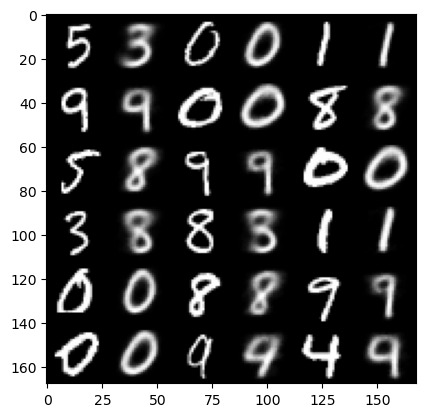

In [11]:
# Реконструкция нескольких изображений из тестового датасета
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
  image, label = test_dataset[index]
  x.append(image)
  y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)

grid = make_samples_grid(x, x_pred)
plt.imshow(grid, cmap="gray")
plt.show()

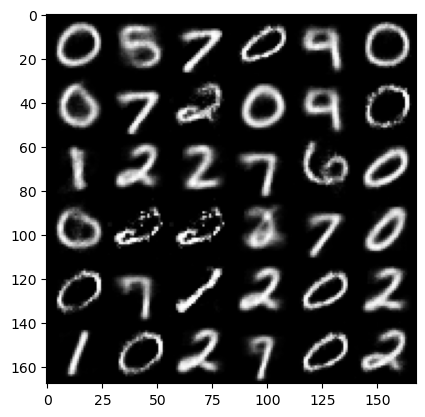

In [16]:
# Генерация сэмплов из шума
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
random_samples = model.decode(random)

grid = make_samples_grid(random_samples)
plt.imshow(grid, cmap="gray")
plt.show()